# **Importing Data & Dependencies**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from keras.models import Sequential
from keras.layers import Dense, Dropout

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

2024-06-12 21:06:19.178235: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 21:06:19.178377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 21:06:19.341657: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
users_df = pd.read_csv("/kaggle/input/users-csv/Users.csv")
ratings_df = pd.read_csv("/kaggle/input/ratings-csv/Ratings.csv")
books_df = pd.read_csv("/kaggle/input/books-csv/Books.csv")

In [3]:
users_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [4]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [5]:
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


# **Preprocessing Data**

In [6]:
# Dropping Image Columns
books_df.drop(books_df.columns[5:], axis=1, inplace=True)

# Merge datasets
merged_df = pd.merge(ratings_df, books_df, on='ISBN')
final_df = pd.merge(merged_df, users_df, on='User-ID')

# Drop NA values
final_df.dropna(inplace=True)

In [7]:
# Replace non-numeric values with '0'
final_df['Year-Of-Publication'] = final_df['Year-Of-Publication'].replace(['Gallimard', 'DK Publishing Inc'], '0')

# Convert specific columns to integers
final_df['User-ID'] = final_df['User-ID'].astype(int)
final_df['Book-Rating'] = final_df['Book-Rating'].astype(int)
final_df['Age'] = final_df['Age'].astype(int)
final_df['Year-Of-Publication'] = final_df['Year-Of-Publication'].astype(int)

# Convert specific columns to strings
final_df['ISBN'] = final_df['ISBN'].astype(str)
final_df['Book-Title'] = final_df['Book-Title'].astype(str)
final_df['Book-Author'] = final_df['Book-Author'].astype(str)
final_df['Publisher'] = final_df['Publisher'].astype(str)
final_df['Location'] = final_df['Location'].astype(str)

In [8]:
# Define which columns are categorical and numerical
categorical_cols = ['ISBN', 'Book-Title', 'Book-Author', 'Publisher', 'Location']
numerical_cols = ['User-ID', 'Age', 'Year-Of-Publication']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

In [9]:
# Take a random subset a sample of the data
subset_df = final_df.sample(frac=0.15, random_state=42)

# Split data into train and test sets
X = final_df.drop(['Book-Rating'], axis=1)
y = final_df['Book-Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Fit and transform preprocessing on training data, and transform on test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# **The Tensorflow Model**

This model is predicting Book-Rating

In [11]:
# Define and compile the model with SGD optimizer and a lower learning rate
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='relu')
])
sgd = SGD(learning_rate=0.01, momentum=0.9)  # Correctly specifying the learning rate parameter
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mean_squared_error'])

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Train the model with larger batch size and early stopping
history = model.fit(X_train_preprocessed, y_train, epochs=10, validation_split=0.2, batch_size=4096, callbacks=[early_stopping])

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - loss: 16.1190 - mean_squared_error: 16.1190 - val_loss: 14.8825 - val_mean_squared_error: 14.8825
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - loss: 14.6488 - mean_squared_error: 14.6488 - val_loss: 13.3816 - val_mean_squared_error: 13.3816
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - loss: 12.9519 - mean_squared_error: 12.9519 - val_loss: 12.7529 - val_mean_squared_error: 12.7529
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - loss: 12.1655 - mean_squared_error: 12.1655 - val_loss: 12.5816 - val_mean_squared_error: 12.5816
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - loss: 12.0237 - mean_squared_error: 12.0237 - val_loss: 12.4442 - val_mean_squared_error: 12.4442
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - loss: 11.4230 - mean_squared_error: 11.4230 - val_loss: 12.8296 - val_mean_squared_error: 12.8296
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - loss: 11.8768

# **Evaluating The Model**

In [12]:
# Evaluate the model
mse, _ = model.evaluate(X_test_preprocessed, y_test)
print("Mean Squared Error:", mse)

4709/4709 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 12.1986 - mean_squared_error: 12.1986
Mean Squared Error: 12.224365234375


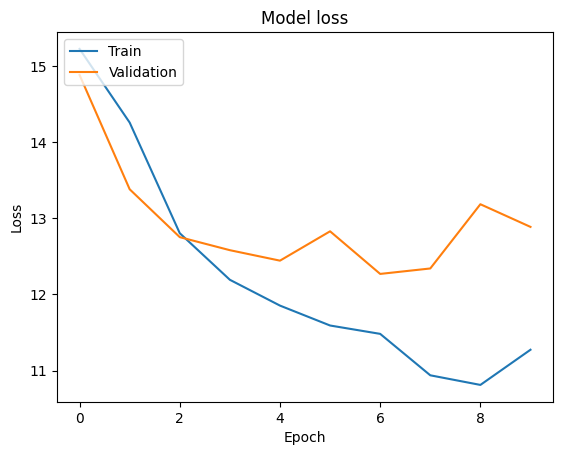

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The model demonstates training and validationdownwards trend, a decreasing loss over epochs. Thus indicating that the model is learning from the data and improving it's predictive ability

# **Book Recommendation**

Using the model, for any given user we can predict and give recommendations on what to read next.

In [14]:
predicted_ratings = model.predict(X_test_preprocessed)
user_id = X_test.iloc[0]['User-ID']
recommended_books = X_test.iloc[np.argsort(predicted_ratings[:,0])[::-1][:5]]

def print_recommendations(recommended_books, user_id):
    print(f"Top 5 recommended books for user {user_id}:\n")
    for i, row in recommended_books.iterrows():
        print(f"Book {i+1}:")
        print(f"Title: {row['Book-Title']}")
        print(f"Author: {row['Book-Author']}")
        print(f"Publisher: {row['Publisher']}")
        print()

# Print the recommended books for the user
print_recommendations(recommended_books, user_id)

4709/4709 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Top 5 recommended books for user 114444:

Book 365626:
Title: Shadows and Light
Author: Anne Bishop
Publisher: Roc

Book 299488:
Title: Jane Eyre
Author: Charlotte Bronte
Publisher: Dorset Press

Book 368146:
Title: Myth Alliances (Myth Adventures, 13)
Author: Robert Asprin
Publisher: Meisha Merlin Publishing

Book 366166:
Title: The Gunslinger (The Dark Tower, Book 1)
Author: Stephen King
Publisher: Viking Books

Book 362616:
Title: Going Postal : A Novel of Discworld (Pratchett, Terry)
Author: Terry Pratchett
Publisher: HarperCollins



# **Saving the Model**

In [15]:
# Save the model
model.save('tf_model.h5')